In [1]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Embedding, Dense, Activation, LSTM
from keras.optimizers import RMSprop

from IPython.display import Image
from keras.utils.visualize_util import plot, model_to_dot

import numpy as np
import random
import sys

%matplotlib inline

Using TensorFlow backend.


In [2]:
class LanguageModel:
    
    def __init__(self, step=3, embed_size=128, seq_length=20):
        """
        step: y is the (step's) word after the x seqence
        embed_size: the ebmedding size of all words
        seq_length: the length of a sequence
        """
        self.seq_length = seq_length
        self.step = step
        self.embed_size = embed_size
    
    def load_data(self, path):
        # read the entire text
        text = open(path).read().strip().replace('\u3000', '').replace('\n', '')
        print('corpus length:', len(text))
        
        # all the vocabularies
        vocab = sorted(list(set(text)))
        print('total words:', len(vocab))

        # create word-index dict
        word_to_index = dict((c, i) for i, c in enumerate(vocab))
        index_to_word = dict((i, c) for i, c in enumerate(vocab))
        
        # cut the text into fixed size sequences
        sentences = []
        next_words = []
        for i in range(0, len(text) - self.seq_length, self.step):
            sentences.append(list(text[i: i+self.seq_length]))
            next_words.append(text[i+self.seq_length])
        print('nb sequences:', len(sentences))
        
        # generate training samples
        X = np.asarray([[word_to_index[w] for w in sent[:]] for sent in sentences])
        y = np.zeros((len(sentences), len(vocab)))
        for i, word in enumerate(next_words):
            y[i, word_to_index[word]] = 1
          
        self.text = text
        self.vocab = vocab
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.X = X
        self.y = y
    
    def load_model(self):
        # load a Sequential model
        model = Sequential()
        model.add(Embedding(len(self.vocab), self.embed_size, input_length=self.seq_length))
        model.add(LSTM(self.embed_size, input_shape=(self.seq_length, self.embed_size), return_sequences=False))
        model.add(Dense(len(self.vocab)))
        model.add(Activation('softmax'))
        
        self.model = model
    
    def visualize_model(self):
        # visualize the model, save to a png file
        plot(self.model, to_file='language_model.png', show_shapes=True)
    
    def compile_model(self, lr=0.01):
        # compile the model
        optimizer = RMSprop(lr=lr)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    def fit_model(self, batch_size=128, nb_epoch=1):
        # fit the model with trainind data
        self.model.fit(self.X, self.y, batch_size, nb_epoch)
        
    def predict(self, x, verbose=0):
        # predict the next word
        return self.model.predict([x], verbose=verbose)[0]
    
    def _sample(self, preds, diversity=1.0):
        # sample from te given prediction
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        
        return np.argmax(probas)
    
    def generate_text(self):
        # generate text from randon text seed
        start_index = random.randint(0, len(self.text) - self.seq_length - 1)
        
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print('----- diversity:', diversity)
        
            generated = ''
            sentence = self.text[start_index: start_index + self.seq_length]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x = np.asarray([self.word_to_index[w] for w in sentence]).reshape([1, self.seq_length])
                preds = self.predict(x)
                next_index = self._sample(preds, diversity)
                next_word = self.index_to_word[next_index]

                generated += next_word
                sentence = sentence[1:] + next_word

                sys.stdout.write(next_word)
                sys.stdout.flush()
            print()                 

In [3]:
model = LanguageModel(seq_length=10)
model.load_data('dataset/sanguoyanyi.txt')

corpus length: 603788
total words: 4001
nb sequences: 201260


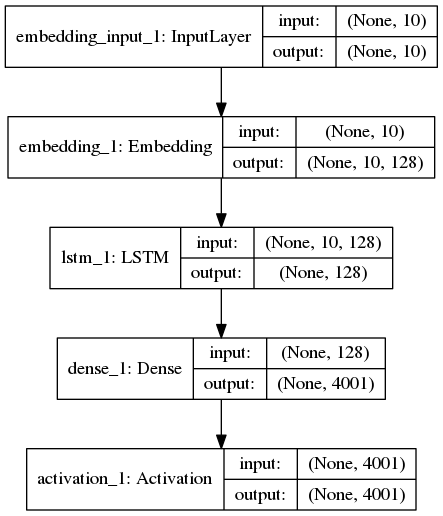

In [4]:
model.load_model()
model.visualize_model()
Image(filename='language_model.png')

In [5]:
model.compile_model()
model.fit_model(nb_epoch=10)

Epoch 1/10
201260/201260 [==============================] - 26s - loss: 5.4223    
Epoch 2/10
201260/201260 [==============================] - 24s - loss: 5.2991    
Epoch 3/10
201260/201260 [==============================] - 24s - loss: 5.3842    
Epoch 4/10
201260/201260 [==============================] - 24s - loss: 5.4167    
Epoch 5/10
201260/201260 [==============================] - 24s - loss: 5.4365    
Epoch 6/10
201260/201260 [==============================] - 25s - loss: 5.4653    
Epoch 7/10
201260/201260 [==============================] - 26s - loss: 5.4970    
Epoch 8/10
201260/201260 [==============================] - 26s - loss: 5.5517    
Epoch 9/10
201260/201260 [==============================] - 26s - loss: 5.5974    
Epoch 10/10
201260/201260 [==============================] - 26s - loss: 5.6459    


In [6]:
for i in range(1, 3):
    print('Iteration:', i)
    model.generate_text()
    print()

Iteration: 1

----- diversity: 0.2
----- Generating with seed: "不捉孙策，更待何时！"
不捉孙策，更待何时！”，故曰：“吾自此，以为何，且看下文分解。第人大惊，乃曰：“吾有一来，以为何？”玄德曰：“吾欲为何，且看下文分解。第人大败，使人，使人。”玄德曰：“今日，以为人，以此人之。”玄德曰：“吾有一曹操，以为人，以此不，以为何。”玄德曰：“吾欲为以之，以此人也。”玄德曰：“此人，以为何，且看下文分解。第人有一时，以为，以为人，只得此人之。”瑜曰：“今日，以为人，以为何不此？”玄德曰：“吾有一此，以为我，以为何，且看下文分解。第人大败，引兵出，即回马，使人。”玄德曰：“今日，以为我，以为何。”玄德曰：“吾引兵，以此人有一为，不可汉中，吾不可，皆来。”孔明曰：“吾自此，不可为，以为何？”玄德曰：“今军不可，以为人，以为何不死。”玄德曰：“吾自此，以为不也！”，故曰：“吾与汝为何，今日，以为何不死。”玄德曰：“吾有一子，以为何，且看：“此人有一时，不可为，必有一为，以为人，以此人之。”玄德曰：“吾无言，

----- diversity: 0.5
----- Generating with seed: "不捉孙策，更待何时！"
不捉孙策，更待何时！”人曰：“吾有兵可行，必有一之，即不得我，岂可来？”玄德曰：“不可关公，以吴兵士，只得船得有一方。玄德闻看见，安杀了。孔明曰：“吾弟，以为成都。”玄德曰：“吾若到，不可江东；故不也。”玄德曰：“此人，只得天下。”操曰：“吾非其言，以为我之。”玄德曰：“吾有兵城下，何也？”乃之曰：“吾自此，两路有取来。”玄德曰：“吾回，可战。”言讫，即领三军入。此有一之，何为。”玄德曰：“吾后，皆卿。”孔明曰：“吾有一为何，且从之。孔明曰：“不得功，皆侯军士，引兵皆兵去。却说孔明曰：“此人来，今若何人？”孔明曰：“吾生自今大夫人，如何不到！”黄祖，左右有一之，不得言，名绍已到，今日为荆州，以为天”！”可操，以此明而去。”玄德曰：“吾皆不得曹操，使吾引兵回去。二人来一城上于路，忽然见一作。”操曰：“吾与汝便得此人，不可请我来。”遂上马于马下，将诸葛亮尽也。却说山上马，为于山之。”玄德曰：“此人不能兵，今日得刘

----- diversity: 1.0
----- Generating 